Oct 7-14 (broken power law)

1. get #GCs by using different random set of parameters from MCMC -> check if it is consistent with the 1-sigma error that I plot, also plot the two lines of +-1sigma to see;

3. divide data into mass bins, calculate the mean and error, plot it;

2. Plot only #GCs of central gal.s vs their M_h;

4. use Planck Pk, generate results with M_form change 10^7 - 10^9; z_form change 6-12;


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy.table import Table

In [3]:
import astropy.io.fits as fits

In [5]:
import corner

In [6]:
import emcee

In [7]:
from scipy.optimize import minimize

In [8]:
from IPython.display import display, Math

do MCMC

In [9]:
#load data 
data = fits.getdata('/data/lemn/results/NGC_Magz.fits')

In [10]:
y = data['NGCs']
x = data['Mag z']
yerr = data['err GC']

In [11]:
a = np.argwhere(~np.isnan(x)) #find idx of non nan values in Mag z

In [12]:
x    = x[a]
y    = y[a]
yerr = yerr[a]

In [13]:
x    = x.reshape((len(a)))
y    = y.reshape((len(a)))
yerr = yerr.reshape((len(a)))

Try with the model as Moster

$y(x) = a\left(\frac{x}{M_1}\right)^{\alpha} + b\left(\frac{x}{M_1}\right)^{\beta}$

In [14]:
def model(theta, x):
    a, alpha, b, beta, M1, log_f = theta
    model = a*(x/M1)**alpha + b*(x/M1)**beta
    return model

In [15]:
def log_likelihood(theta, x, y, yerr):
    a, alpha, b, beta, M1, log_f = theta
    sigma2 = yerr**2 + model(theta,x)**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model(theta,x)) ** 2 / sigma2 + np.log(sigma2))


In [16]:
#initial values (guess)
a_ini     = 5
alpha_ini = 2 
b_ini     = 8
beta_ini  = 2
M1_ini    = -20
f_ini     = 0.2 
ini  = np.array([a_ini, alpha_ini, b_ini, beta_ini, M1_ini, np.log(f_ini)]) 
ndim = len(ini)

In [17]:
np.random.seed(42)
nll     = lambda *args: -log_likelihood(*args)
initial = ini + 1e-3 * np.random.randn(ndim)
soln    = minimize(nll, initial, args=(x, y, yerr))
a_ml, alpha_ml, b_ml, beta_ml, M1_ml, log_f_ml = soln.x

theta_ml = [a_ml, alpha_ml, b_ml, beta_ml, M1_ml, log_f_ml]

print("Maximum likelihood estimates:")
print("a     = {0:.3f}".format(a_ml))
print("alpha = {0:.3f}".format(alpha_ml))
print("b     = {0:.3f}".format(b_ml))
print("beta  = {0:.3f}".format(beta_ml))
print("M1    = {0:.3f}".format(M1_ml))
print("f     = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
a     = 15.651
alpha = 0.865
b     = 19.523
beta  = 27.113
M1    = -19.223
f     = 0.799


In [18]:
def log_prior(theta):
    a, alpha, b, beta, M1, log_f = theta
    if 0. < a < 30. and -5 < alpha < 5 and 0 < b < 30000 and 0 < beta < 40. and -25 < M1 < -15 and -10.0 < log_f < 10:
        return 0.0
    return -np.inf

In [19]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


In [20]:
nwalkers = 240 # no. of paramters x 40
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)
niter = 70000  # nwalkers x 1000

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
sampler.run_mcmc(pos, niter, progress=True);

You must install the tqdm library to use progress indicators with emcee


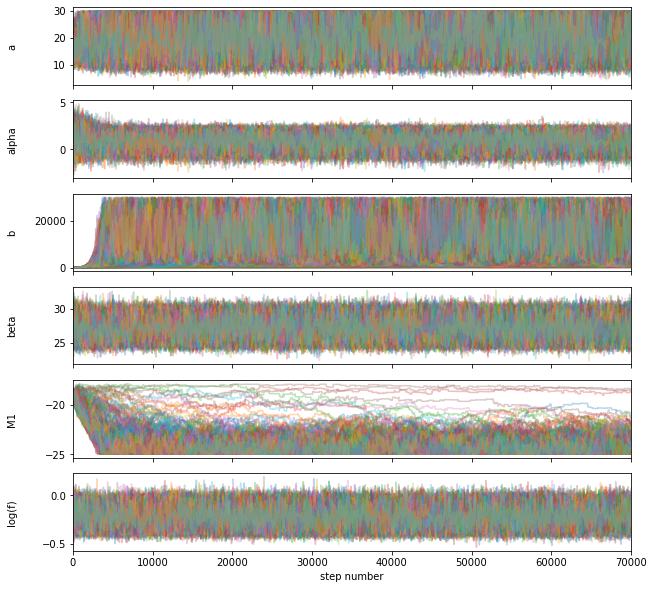

In [21]:
fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ["a", 'alpha', "b", 'beta', 'M1', "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [23]:
flat_samples = sampler.get_chain(discard=100, thin=500, flat=True) #thin the samples ~ 0.5 of autocorr time
print(flat_samples.shape)

(33360, 6)


In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

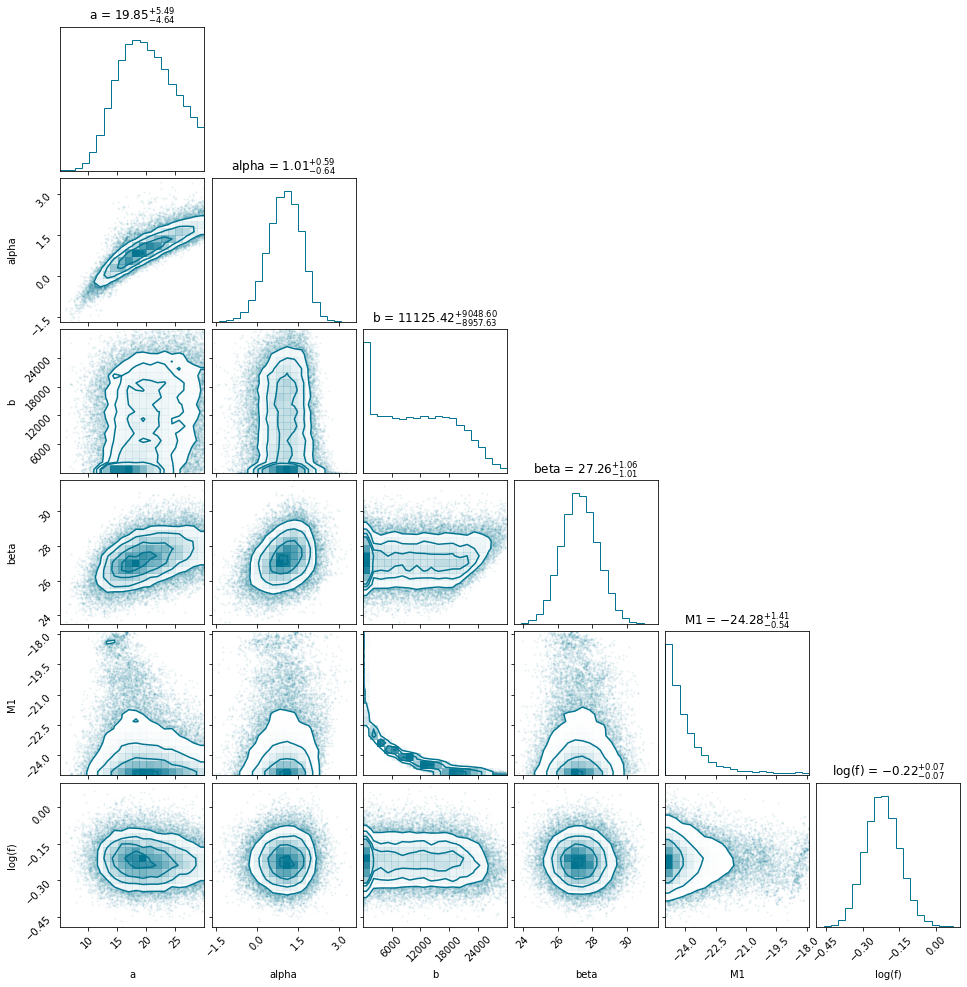

In [28]:
fig = corner.corner(flat_samples, show_titles=True,labels=labels, color='#047591')
#fig.savefig('corner_constrain.pdf')

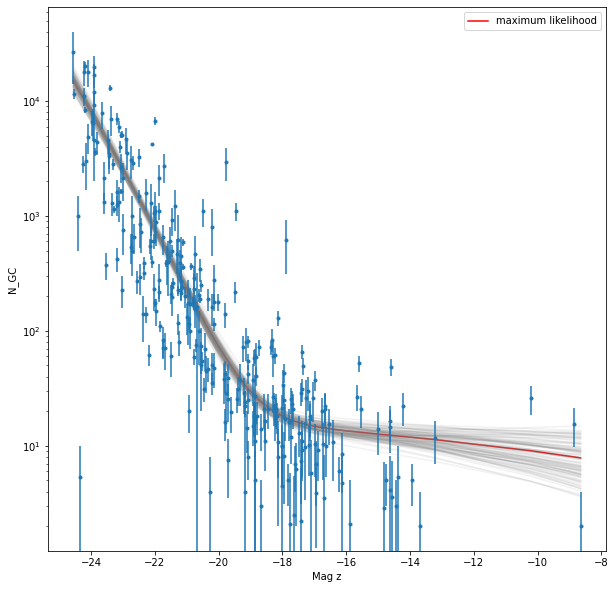

In [29]:
inds = np.random.randint(len(flat_samples), size=100)
plt.figure(figsize=(10,10))
plt.yscale('log')
models = []
x2 = np.sort(x)
plt.plot(x2, model(theta_ml, x2), 'r-', label = 'maximum likelihood')
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x2, model(sample,x2), color='grey', alpha = 0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".", capsize=0)
plt.xlabel("Mag z")
plt.ylabel("N_GC")
plt.legend()
#plt.savefig('parameters_100.pdf')

In [30]:
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{+{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

1. get #GCs by using different random set of parameters from MCMC -> check if it is consistent with the 1-sigma error that I plot, also plot the two lines of +-1sigma to see;

In [31]:
theta       = np.zeros(ndim)
theta_plus  = np.zeros(ndim)
theta_minus = np.zeros(ndim)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    theta[i] = mcmc[1]
    theta_plus[i] = theta[i] + q[1]
    theta_minus[i] = theta[i] - q[0]

plot the mean and +-1sigma error lines

generate #GCs at one Mag_z, using different parameter sets to see whether it is Gaussian or not

In [32]:
Mag_test = np.arange(-28,-10,0.5)
print(len(Mag_test))

36


In [47]:
sigma = np.zeros(len(Mag_test))
NN = np.zeros(len(Mag_test))
for j in range(0,len(Mag_test)):
    N_test = np.zeros(len(flat_samples))#inds))
    i = 0
    for ind in range(0,len(flat_samples)):#inds:
        sample = flat_samples[ind]
        N_test[i] = model(sample,Mag_test[j])
        i+= 1
    sigma[j] = np.std(N_test)
    NN[j] = np.mean(N_test)
    #print( model(theta_minus,Mag_test[j]),model(theta,Mag_test[j]), model(theta_plus,Mag_test[j]))
    #plt.hist(N_test)
    #plt.title('Mag_z = '+ str(Mag_test[j]))
    #plt.show()

<ErrorbarContainer object of 3 artists>

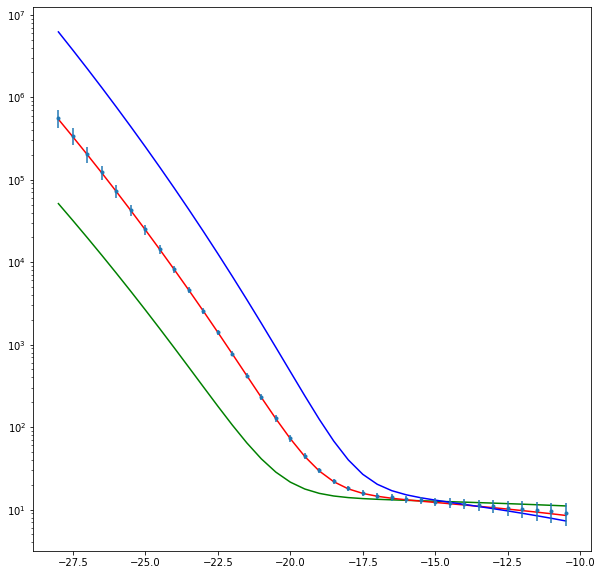

In [48]:
plt.figure(figsize=(10,10))
plt.yscale('log')
plt.xlabel('Mag z-band')
plt.ylabel('#GCs')
plt.plot(Mag_test, model(theta_minus,Mag_test),'g-',labels='16%')
plt.plot(Mag_test, model(theta,Mag_test),'r-',labels='50%')
plt.plot(Mag_test, model(theta_plus,Mag_test),'b-',labels='84')
plt.errorbar(Mag_test,NN, yerr = sigma, fmt='.',labels='1-sigma deviation after apply on data')
plt.legend()

- This 1-sigma parameter sets result is too much bigger than the 1-sigma results after applying on Mag_z

- Does it make sense to use this 1-sigma rather than the 1-sigma from paramter sets? it aligns to the mean theta value.

- try to apply it on the Yang catalog

In [49]:
path='/data/lemn/DESIdata/'

In [53]:
from tqdm import tqdm

In [50]:
#load Mag z
data = fits.getdata(path+'galaxies/DESIDR9_NGC_galaxy.fits')

In [51]:
Mag_z = data['M_zband']

In [58]:
#randomly pick 100 parameter sets out of the samples
inds = np.random.randint(len(flat_samples), size=100)

In [59]:
sig = np.zeros(len(Mag_z))
NGC = np.zeros(len(Mag_z))
for j in tqdm(range(0,len(Mag_z))):
    N_test = np.zeros(len(inds))#flat_samples))
    i = 0
    for ind in inds:#flat_samples:
        sample = flat_samples[ind]
        N_test[i] = model(sample,Mag_z[j])
        i+= 1
    sig[j] = np.std(N_test)
    NGC[j] = np.mean(N_test)

100%|██████████| 67197600/67197600 [5:12:47<00:00, 3580.44it/s]  


In [38]:
#reload NGC since kernel died once
data5 = fits.getdata('/data/lemn/results/NGCs_each_Yang_gal_avg100samples.fits')
NGC = data5['NGCs']
err_each = data5['sigma']

now take the sum of number of GCs in groups, and match it to halo mass of groups

In [40]:
#load infor of members in group
mem = fits.getdata(path+'members/iDESIDR9_NGC_1.fits')

In [41]:
igroup_ID = mem['groupID']

In [34]:
#load infor of members in group
group = fits.getdata(path+'groups/DESIDR9_NGC_group.fits')

In [35]:
group_ID = group['groupID']

In [67]:
richness = group['richness']

In [68]:
richness = richness.astype(int)

In [42]:
M_group = group['log M_h [M_sun/h]'] #[M_sun/h]

In [43]:
h = 0.67                    #Planck parameters
M_group = 10**(M_group)*h  # [M_sun], unit in catalog is log10 Msun

In [71]:
sort_id = np.argsort(igroup_ID)

In [72]:
tot_GC = np.zeros(len(M_group))
err_GC = np.zeros(len(M_group))

In [73]:
#the remaining terms
start = 0
for i in range(0,len(M_group)):
    stop = start + richness[i]
    for j in range(start,stop):
        tot_GC[i] += NGC[sort_id[j]]
        err_GC[i] += sig[sort_id[j]]
    start = stop

In [4]:
#haha kernel die so I load it from file
data4 = fits.getdata('/data/lemn/results/Mh_NGCs_avg100samples.fits')
M_group = data4['M halo']
tot_GC  = data4['tot NGCs']
err_GC  = data4['1-sigma']

now plot this error on top of the 1-sigma parameters error

In [19]:
i_plot = np.random.rand(100,100)
i_plot *= len(M_group)
i_plot = i_plot.reshape(10000)
i_plot = i_plot.astype(int)

In [77]:
asymmetric_error = [lower_err[i_plot], upper_err[i_plot]]

In [6]:
#load theory results
M_halo_theo                 = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(0))
N_GC_Mill_Creaseytheo       = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(1))
err_N_GC_Mill_Creaseytheo   = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(2))
N_GC_Planck_Creaseytheo     = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(3))
err_N_GC_Planck_Creaseytheo = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(4))
N_GC_COCO_Creaseytheo       = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(5))
err_N_GC_COCO_Creaseytheo   = np.loadtxt("/data/lemn/theory_results/theory_Creaseymodel.txt" ,usecols=(6))
M_halo_theo2                = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(0))
N_GC_Mill_ourtheo           = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(1))
err_N_GC_Mill_ourtheo       = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(2))
N_GC_Planck_ourtheo         = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(3))
err_N_GC_Planck_ourtheo     = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(4))
N_GC_COCO_ourtheo           = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(5))
err_N_GC_COCO_ourtheo       = np.loadtxt("/data/lemn/theory_results/theory_ourmodel.txt"     ,usecols=(6))

In [7]:
# load EMOSAICS Fig.1 data
mass_E   = np.loadtxt('/data/lemn/datalit/EMOSAICS_data.txt', usecols =(0))
triangle = np.loadtxt('/data/lemn/datalit/EMOSAICS_data.txt', usecols =(1))
square   = np.loadtxt('/data/lemn/datalit/EMOSAICS_data.txt', usecols =(2))
star     = np.loadtxt('/data/lemn/datalit/EMOSAICS_data.txt', usecols =(3))

In [8]:
#load Forbes 18 data
M_halo_F = np.loadtxt('/data/lemn/datalit/Forbes18_data.txt',usecols=(2))
N_GC_F   = np.loadtxt('/data/lemn/datalit/Forbes18_data.txt',usecols=(3))
M_halo_F = 10**M_halo_F

In [9]:
#load blue GCs from Creasey data
M_Creasey = np.loadtxt('/data/lemn/datalit/Creasey_Data.txt',usecols=(0))
N_Creasey = np.loadtxt('/data/lemn/datalit/Creasey_Data.txt',usecols=(1))

In [10]:
Atlas_H = fits.getdata('/data/lemn/results/M_h_NGCs_Harris-Atlas.fits')

In [11]:
check     = Atlas_H['check T F central']
sum_NGC   = Atlas_H['NGCs']
M_h_array = Atlas_H['M_h M_sun']

In [12]:
check2 =np.argwhere(check==1)

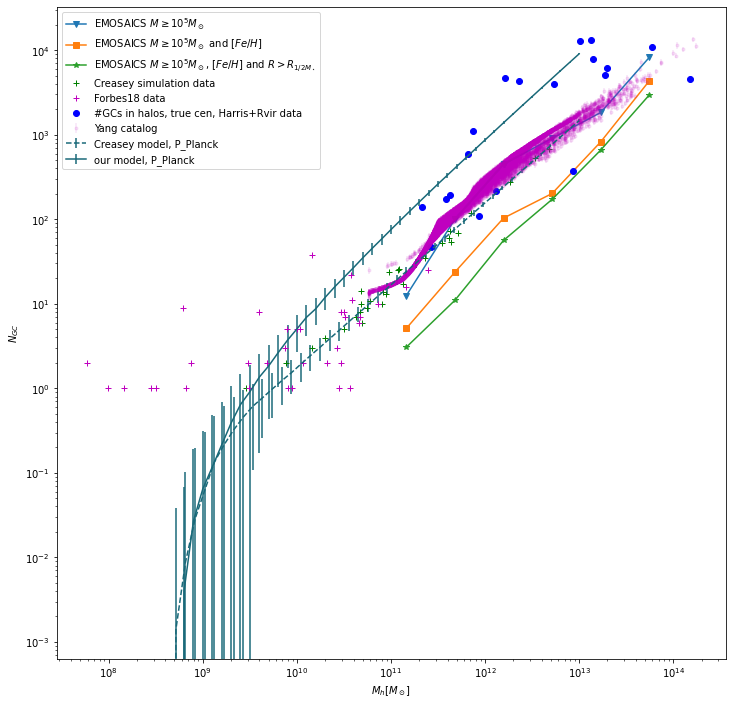

In [27]:

plt.figure(figsize=(12,12))
plt.xscale("log")
plt.yscale('log')

plt.errorbar(M_group[i_plot], tot_GC[i_plot], yerr =err_GC[i_plot], fmt= 'm.',alpha = 0.1,label='Yang catalog' )

#plt.errorbar(M_halo_theo, N_GC_Mill_Creaseytheo,  yerr=err_N_GC_Mill_Creaseytheo,  color = '#a5c215', fmt='--',label='Creasey model, P_Mill')
plt.errorbar(M_halo_theo, N_GC_Planck_Creaseytheo,yerr=err_N_GC_Planck_Creaseytheo,color = '#186878', fmt='--',label='Creasey model, P_Planck')
#plt.errorbar(M_halo_theo, N_GC_COCO_Creaseytheo,  yerr=err_N_GC_COCO_Creaseytheo,  color = '#c23215', fmt='--',label='Creasey model, P_COCO WDM')
#plt.errorbar(M_halo_theo2,N_GC_Mill_ourtheo,      yerr=err_N_GC_Mill_ourtheo,      color = '#a5c215',label='our model, P_Mill')
plt.errorbar(M_halo_theo2,N_GC_Planck_ourtheo,    yerr=err_N_GC_Planck_ourtheo,    color = '#186878',label='our model, P_Planck')
#plt.errorbar(M_halo_theo2,N_GC_COCO_ourtheo,      yerr=err_N_GC_COCO_ourtheo,      color = '#c23215',label='our model, P_COCO WDM')

plt.plot(mass_E, triangle, 'v-', label = 'EMOSAICS $M \geq 10^5 M_\odot$')
plt.plot(mass_E, square,   's-', label = 'EMOSAICS $M \geq 10^5 M_\odot$ and $[Fe/H]$')
plt.plot(mass_E, star, '*-',     label = 'EMOSAICS $M \geq 10^5 M_\odot$, $[Fe/H]$ and $R > R_{1/2 M_\star}$')

plt.plot(M_Creasey, N_Creasey, 'g+', label ='Creasey simulation data')
plt.plot(M_halo_F, N_GC_F, 'm+',     label ='Forbes18 data')

plt.plot(M_h_array[check2],sum_NGC[check2], 'bo', label = '#GCs in halos, true cen, Harris+Rvir data')
#plt.xlim(5e10,5e11)
plt.xlabel('$M_h [M_\odot]$')
plt.ylabel('$N_{GC}$')
plt.legend()
#plt.savefig('tot_GC_1sigma.pdf')
plt.show()

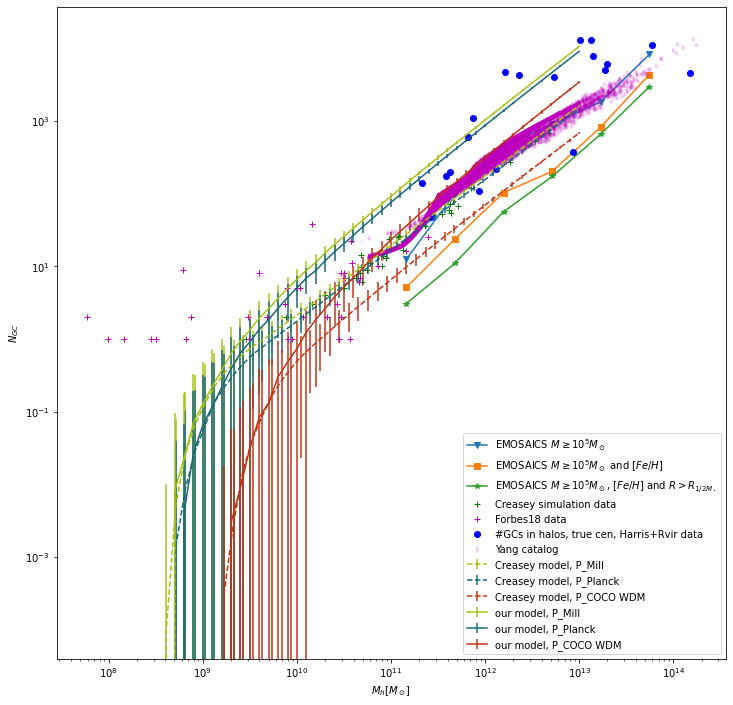

In [21]:

plt.figure(figsize=(12,12))
plt.xscale("log")
plt.yscale('log')

plt.errorbar(M_group[i_plot], tot_GC[i_plot], yerr =err_GC[i_plot], fmt= 'm.',alpha = 0.1,label='Yang catalog' )

plt.errorbar(M_halo_theo, N_GC_Mill_Creaseytheo,  yerr=err_N_GC_Mill_Creaseytheo,  color = '#a5c215', fmt='--',label='Creasey model, P_Mill')
plt.errorbar(M_halo_theo, N_GC_Planck_Creaseytheo,yerr=err_N_GC_Planck_Creaseytheo,color = '#186878', fmt='--',label='Creasey model, P_Planck')
plt.errorbar(M_halo_theo, N_GC_COCO_Creaseytheo,  yerr=err_N_GC_COCO_Creaseytheo,  color = '#c23215', fmt='--',label='Creasey model, P_COCO WDM')
plt.errorbar(M_halo_theo2,N_GC_Mill_ourtheo,      yerr=err_N_GC_Mill_ourtheo,      color = '#a5c215',label='our model, P_Mill')
plt.errorbar(M_halo_theo2,N_GC_Planck_ourtheo,    yerr=err_N_GC_Planck_ourtheo,    color = '#186878',label='our model, P_Planck')
plt.errorbar(M_halo_theo2,N_GC_COCO_ourtheo,      yerr=err_N_GC_COCO_ourtheo,      color = '#c23215',label='our model, P_COCO WDM')

plt.plot(mass_E, triangle, 'v-', label = 'EMOSAICS $M \geq 10^5 M_\odot$')
plt.plot(mass_E, square,   's-', label = 'EMOSAICS $M \geq 10^5 M_\odot$ and $[Fe/H]$')
plt.plot(mass_E, star, '*-',     label = 'EMOSAICS $M \geq 10^5 M_\odot$, $[Fe/H]$ and $R > R_{1/2 M_\star}$')

plt.plot(M_Creasey, N_Creasey, 'g+', label ='Creasey simulation data')
plt.plot(M_halo_F, N_GC_F, 'm+',     label ='Forbes18 data')

plt.plot(M_h_array[check2],sum_NGC[check2], 'bo', label = '#GCs in halos, true cen, Harris+Rvir data')

plt.xlabel('$M_h [M_\odot]$')
plt.ylabel('$N_{GC}$')
plt.legend()
#plt.savefig('tot_GC_1sigma.pdf')
plt.show()

2. now  calculate the mass bin

In [57]:
#sort mass and other arrays in order of increasing mass, to divide into bins
arg_sort = np.argsort(M_group)

In [58]:
M_sort = M_group[arg_sort]
N_sort = tot_GC[arg_sort]
err_sort = err_GC[arg_sort]

In [59]:
#create the mass bin array
nbin = 101
M_bin = np.logspace(np.log10(M_sort[0]), np.log10(M_sort[len(M_sort)-1]),nbin)

In [60]:
N_mean = np.zeros(nbin-1)
M_mean = np.zeros(nbin-1)

In [61]:
j = 0
stop = -1
for i in range(0,len(M_sort)):
    start = stop + 1
    if M_sort[i] > M_bin[j]:   #take sum of all the points within mass bin, if point larger, move to next bins
        stop = i-1       
        N_mean[j] = np.mean(N_sort[start:stop])
        M_mean[j] = np.mean(M_sort[start:stop])
        j += 1
        #print(stop)
        
#last bin, for the remain points
start = stop + 1
stop = len(M_sort)
N_mean[j] = np.mean(N_sort[start:stop])
M_mean[j] = np.mean(M_sort[start:stop])

/cluster/home/lemn/.conda/envs/project2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/cluster/home/lemn/.conda/envs/project2/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


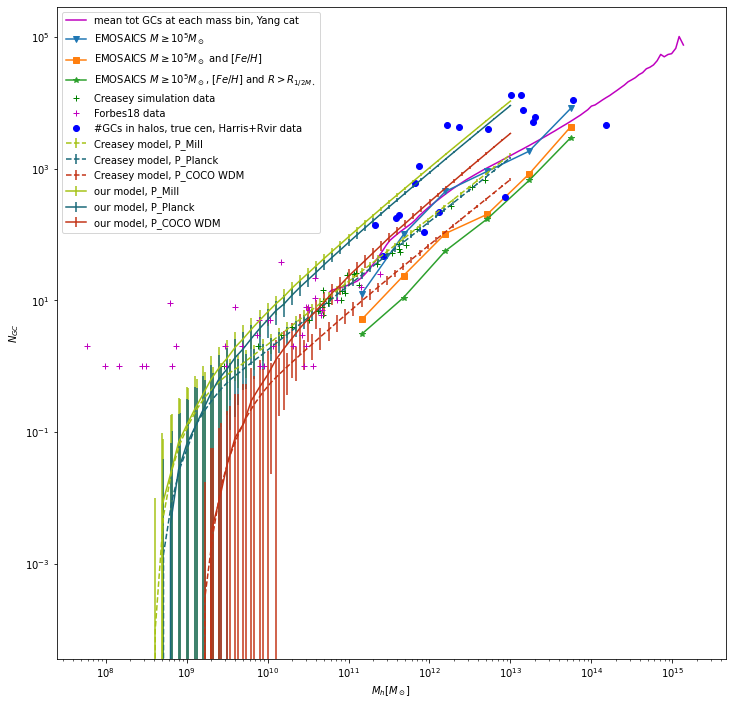

In [63]:

plt.figure(figsize=(12,12))
plt.xscale("log")
plt.yscale('log')

plt.plot(M_mean, N_mean,'m',label='mean tot GCs at each mass bin, Yang cat')

plt.errorbar(M_halo_theo, N_GC_Mill_Creaseytheo,  yerr=err_N_GC_Mill_Creaseytheo,  color = '#a5c215', fmt='--',label='Creasey model, P_Mill')
plt.errorbar(M_halo_theo, N_GC_Planck_Creaseytheo,yerr=err_N_GC_Planck_Creaseytheo,color = '#186878', fmt='--',label='Creasey model, P_Planck')
plt.errorbar(M_halo_theo, N_GC_COCO_Creaseytheo,  yerr=err_N_GC_COCO_Creaseytheo,  color = '#c23215', fmt='--',label='Creasey model, P_COCO WDM')
plt.errorbar(M_halo_theo2,N_GC_Mill_ourtheo,      yerr=err_N_GC_Mill_ourtheo,      color = '#a5c215',label='our model, P_Mill')
plt.errorbar(M_halo_theo2,N_GC_Planck_ourtheo,    yerr=err_N_GC_Planck_ourtheo,    color = '#186878',label='our model, P_Planck')
plt.errorbar(M_halo_theo2,N_GC_COCO_ourtheo,      yerr=err_N_GC_COCO_ourtheo,      color = '#c23215',label='our model, P_COCO WDM')

plt.plot(mass_E, triangle, 'v-', label = 'EMOSAICS $M \geq 10^5 M_\odot$')
plt.plot(mass_E, square,   's-', label = 'EMOSAICS $M \geq 10^5 M_\odot$ and $[Fe/H]$')
plt.plot(mass_E, star, '*-',     label = 'EMOSAICS $M \geq 10^5 M_\odot$, $[Fe/H]$ and $R > R_{1/2 M_\star}$')

plt.plot(M_Creasey, N_Creasey, 'g+', label ='Creasey simulation data')
plt.plot(M_halo_F, N_GC_F, 'm+',     label ='Forbes18 data')

plt.plot(M_h_array[check2],sum_NGC[check2], 'bo', label = '#GCs in halos, true cen, Harris+Rvir data')

plt.xlabel('$M_h [M_\odot]$')
plt.ylabel('$N_{GC}$')
plt.legend()
#plt.savefig('tot_GC_1sigma.pdf')
plt.show()

3. plot only central galaxies' GCs vs halo mass, to compare to EMOSAICS

In [29]:
path='/data/lemn/DESIdata/'

In [30]:
cen_check = np.loadtxt(path+'members/iDESIDR9_NGC_1', usecols=(2))

In [31]:
cen_no = np.argwhere(cen_check==1) #take arg of central galaxies
print(cen_no)

[[       0]
 [       1]
 [       3]
 ...
 [67197596]
 [67197597]
 [67197599]]


In [39]:
N_cen = NGC[cen_no]

In [54]:
N_cen = N_cen.reshape(len(cen_no))

In [50]:
err_cen = err_each[cen_no]

In [55]:
err_cen = err_cen.reshape(len(cen_no))

In [44]:
group_id_cen = igroup_ID[cen_no]

In [46]:
group_id_cen = group_id_cen.reshape(len(cen_no))

In [47]:
group_id_cen = group_id_cen.astype(int)

In [49]:
M_cen = M_group[group_id_cen-1] #minus one since the indices of groups count from 1, while the arg of array start from 0

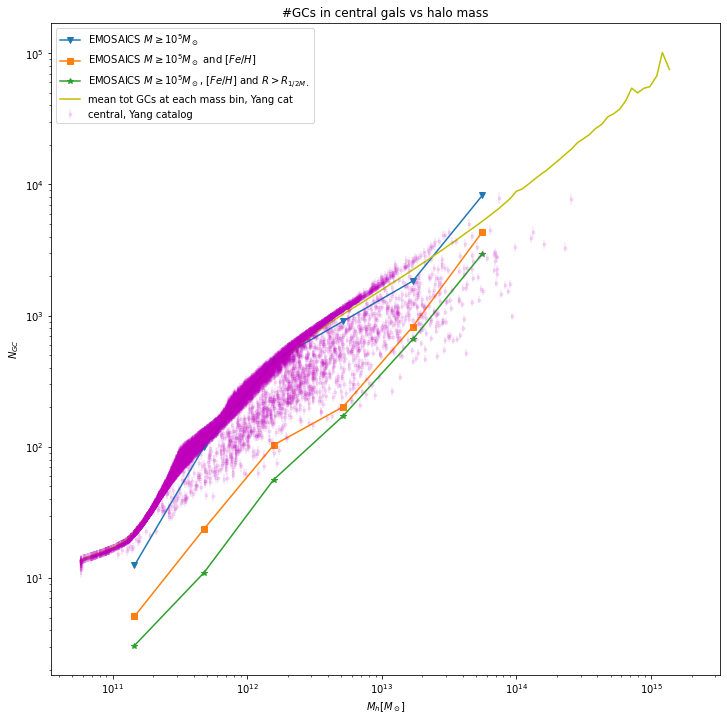

In [66]:
plt.figure(figsize=(12,12))
plt.xscale("log")
plt.yscale('log')

plt.errorbar(M_cen[i_plot], N_cen[i_plot], yerr = err_cen[i_plot], fmt= 'm.',alpha = 0.1,label='central, Yang catalog' )
plt.plot(mass_E, triangle, 'v-', label = 'EMOSAICS $M \geq 10^5 M_\odot$')
plt.plot(mass_E, square,   's-', label = 'EMOSAICS $M \geq 10^5 M_\odot$ and $[Fe/H]$')
plt.plot(mass_E, star, '*-',     label = 'EMOSAICS $M \geq 10^5 M_\odot$, $[Fe/H]$ and $R > R_{1/2 M_\star}$')
plt.plot(M_mean, N_mean,'y',label='mean tot GCs at each mass bin, Yang cat')

plt.xlabel('$M_h [M_\odot]$')
plt.ylabel('$N_{GC}$')
plt.legend()
plt.title('#GCs in central gals vs halo mass')
plt.savefig('GC_central.pdf')
plt.show()